<a href="https://colab.research.google.com/github/mirzaleiva2-cell/Clustering-assignment/blob/main/Clustering__assignment_Mirza_Leiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basics
import numpy as np, pandas as pd
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

# Try BisectingKMeans if available
try:
    from sklearn.cluster import BisectingKMeans
    HAS_BISECT = True
except Exception:
    HAS_BISECT = False

np.random.seed(42)


In [ ]:
def load_all():
    data = {
        "Iris": load_iris(as_frame=True),
        "Wine": load_wine(as_frame=True),
        "BreastCancer": load_breast_cancer(as_frame=True),
        "Digits": load_digits(as_frame=True)
    }
    # Standardize features for all (helps K-Means, Agglomerative, DBSCAN)
    out = {}
    for name, ds in data.items():
        X = ds.data.values
        y = ds.target.values
        Xs = StandardScaler().fit_transform(X)
        out[name] = {"X": Xs, "y": y, "feature_names": ds.feature_names}
    return out

datasets = load_all()
list(datasets.keys())


['Iris', 'Wine', 'BreastCancer', 'Digits']

In [ ]:
def safe_silhouette(X, labels):
    # For DBSCAN, drop noise (-1); for single-cluster, return NaN
    mask = labels != -1
    uniq = np.unique(labels[mask])
    if len(uniq) < 2:
        return np.nan
    return silhouette_score(X[mask], labels[mask])

def run_algos(X, y, k_rep, dbscan_params=(0.5, 5)):
    """Fit all requested algorithms on one dataset and return a results list."""
    eps, min_samples = dbscan_params
    algos = {
        "KMeans (random init)": KMeans(n_clusters=k_rep, init="random", n_init=10, random_state=42),
        "KMeans++": KMeans(n_clusters=k_rep, init="k-means++", n_init=10, random_state=42),
        "Agglomerative (Ward)": AgglomerativeClustering(n_clusters=k_rep, linkage="ward"),
        "Agglomerative (Complete)": AgglomerativeClustering(n_clusters=k_rep, linkage="complete"),
        "DBSCAN": DBSCAN(eps=eps, min_samples=min_samples)
    }
    if HAS_BISECT:
        algos["Bisecting KMeans"] = BisectingKMeans(n_clusters=k_rep, random_state=42)

    results = []
    for name, model in algos.items():
        model.fit(X)
        labels = getattr(model, "labels_", None)
        inertia = getattr(model, "inertia_", np.nan)
        sil = safe_silhouette(X, labels)
        ari = adjusted_rand_score(y, labels) if y is not None else np.nan
        results.append({"algorithm": name, "k_or_params": k_rep if name!="DBSCAN" else f"eps={eps},min={min_samples}",
                        "inertia": inertia, "silhouette": sil, "ARI": ari, "labels": labels})
    return results

def plot_clusters(X, labels, title):
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(5,4))
    plt.scatter(X2[:,0], X2[:,1], c=labels, s=12)  # Colab will choose default colors
    plt.title(title)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
    plt.show()


In [ ]:
rep_k = {
    "Iris": 3,
    "Wine": 3,
    "BreastCancer": 2,
    "Digits": 10
}
# Quick DBSCAN starting points (you can tune later)
dbscan_defaults = {
    "Iris": (0.6, 5),
    "Wine": (1.5, 8),
    "BreastCancer": (1.2, 8),
    "Digits": (7.0, 10)
}


In [ ]:
all_rows = []
store_labels = {}  # for later plots

for name, pack in datasets.items():
    X, y = pack["X"], pack["y"]
    k = rep_k[name]
    res = run_algos(X, y, k_rep=k, dbscan_params=dbscan_defaults[name])
    for r in res:
        row = r.copy()
        row.pop("labels")
        row["dataset"] = name
        all_rows.append(row)
        # Save labels for visualization
        key = f"{name} | {r['algorithm']}"
        store_labels[key] = r["labels"]

df_results = pd.DataFrame(all_rows).sort_values(["dataset","algorithm"]).reset_index(drop=True)
df_results


,algorithm,k_or_params,inertia,silhouette,ARI,dataset
0,Agglomerative (Complete),2,NaN,0.660667,0.004828,BreastCancer
1,Agglomerative (Ward),2,NaN,0.339385,0.575041,BreastCancer
2,Bisecting KMeans,2,11595.683313,0.344734,0.676505,BreastCancer
3,DBSCAN,"eps=1.2,min=8",NaN,NaN,0.000000,BreastCancer
4,KMeans (random init),2,11595.526607,0.343382,0.653625,BreastCancer
5,KMeans++,2,11595.526607,0.343382,0.653625,BreastCancer
6,Agglomerative (Complete),10,NaN,0.385738,0.000298,Digits
7,Agglomerative (Ward),10,NaN,0.125325,0.664346,Digits
8,Bisecting KMeans,10,73453.298894,0.108082,0.446168,Digits
9,DBSCAN,"eps=7.0,min=10",NaN,NaN,0.000399,Digits


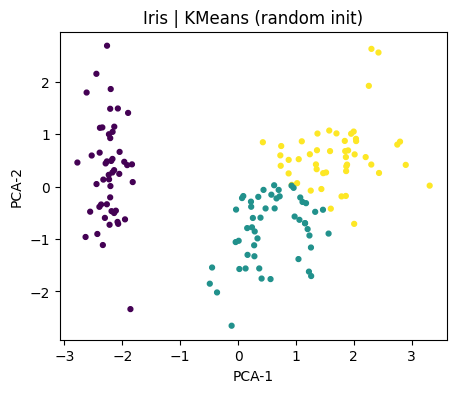

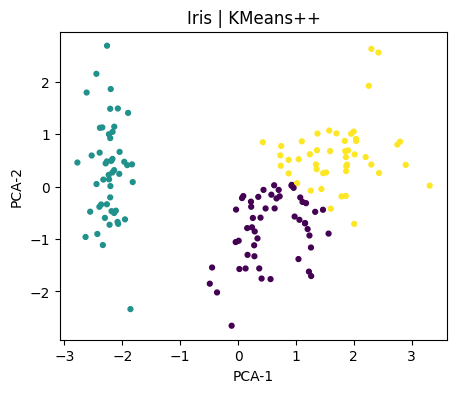

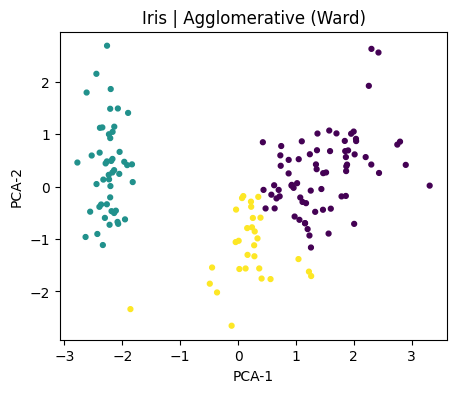

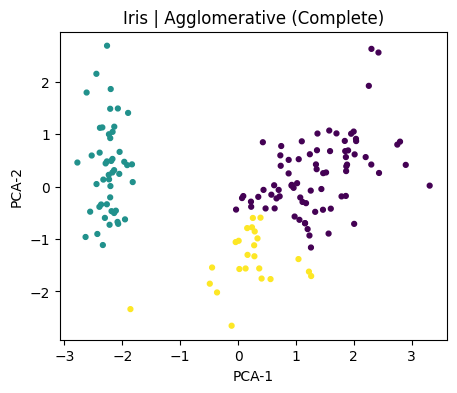

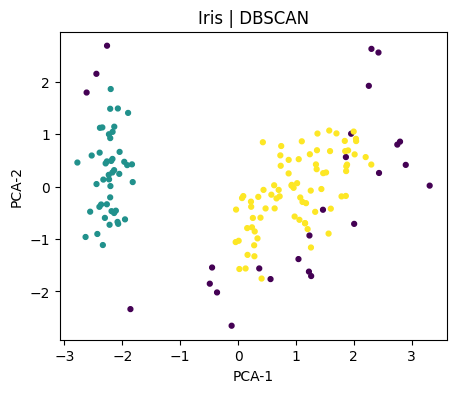

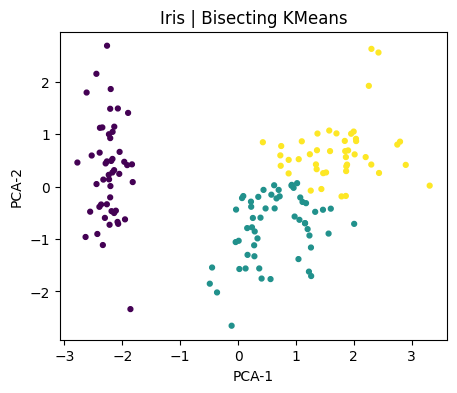

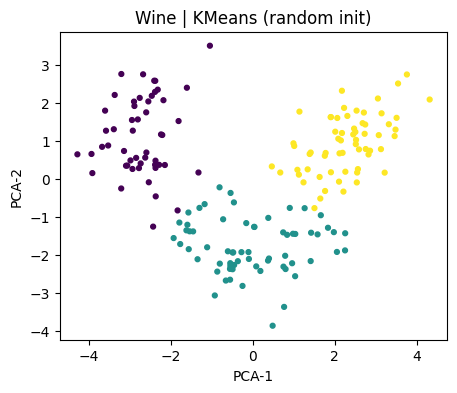

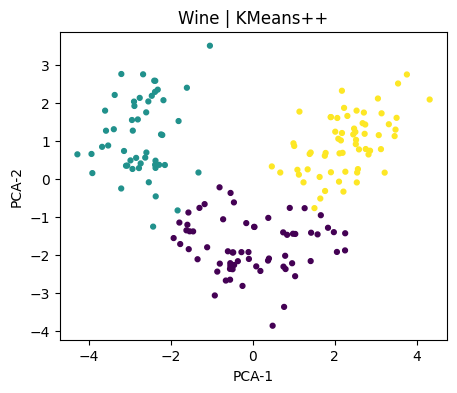

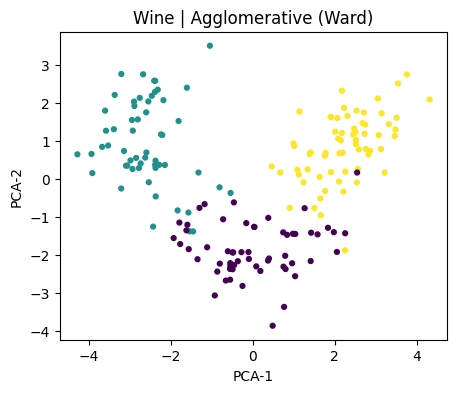

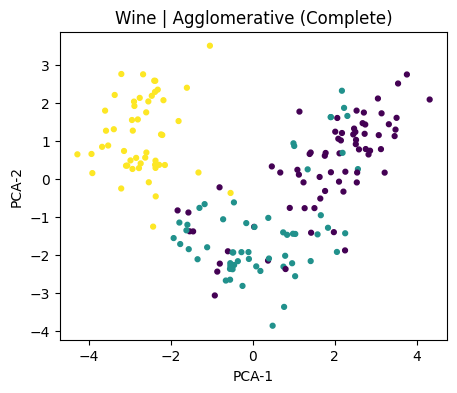

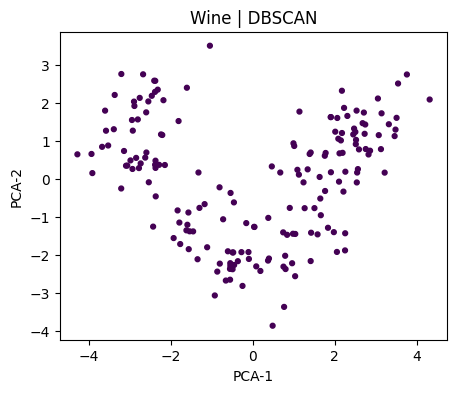

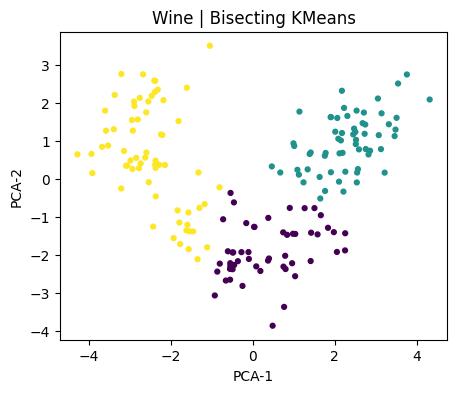

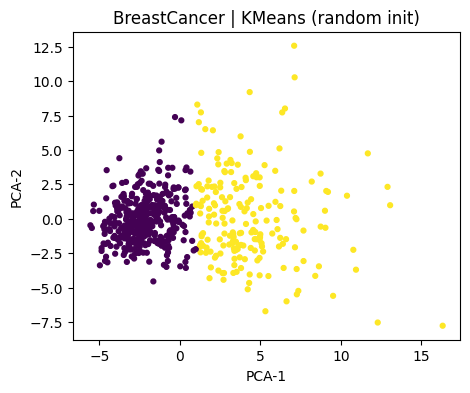

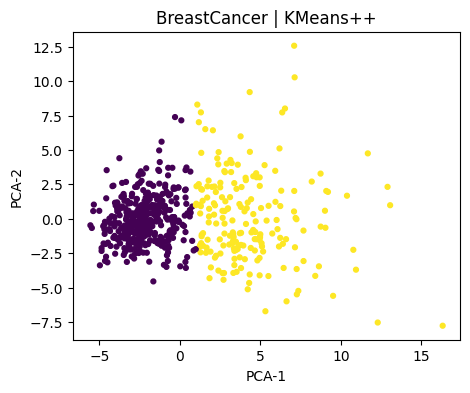

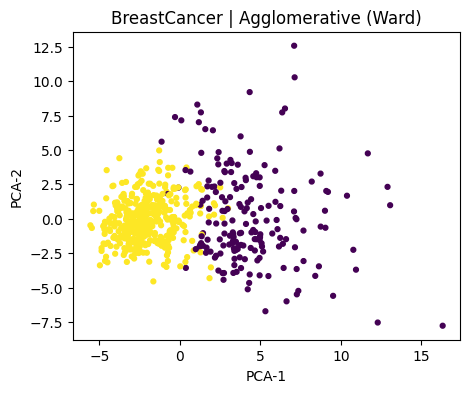

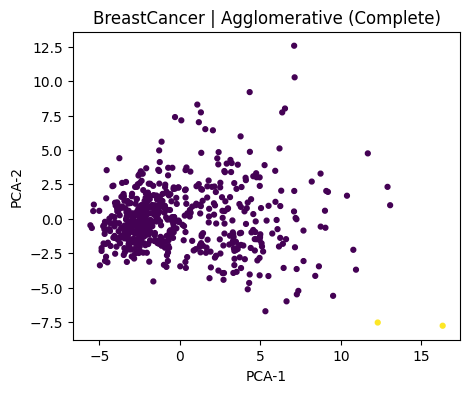

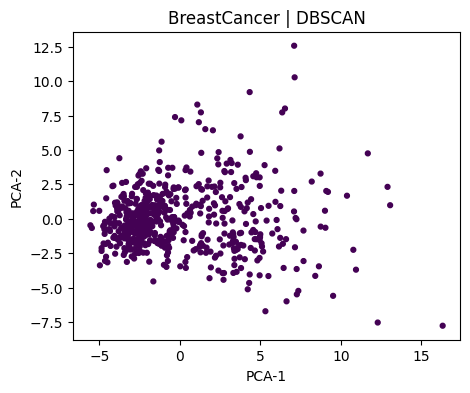

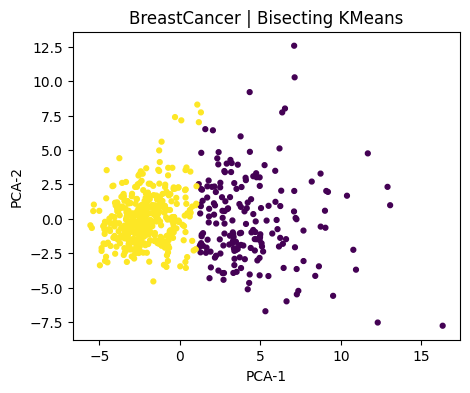

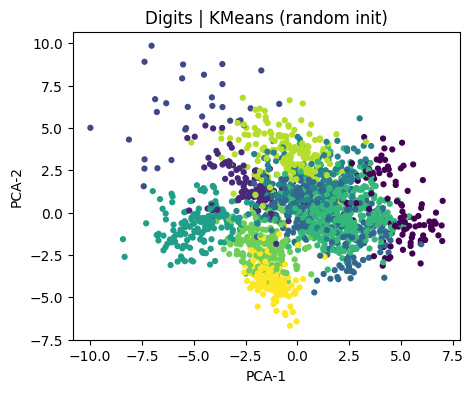

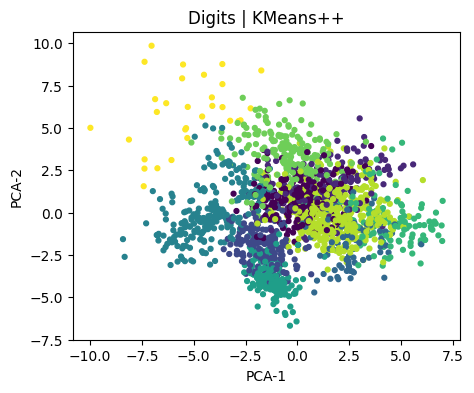

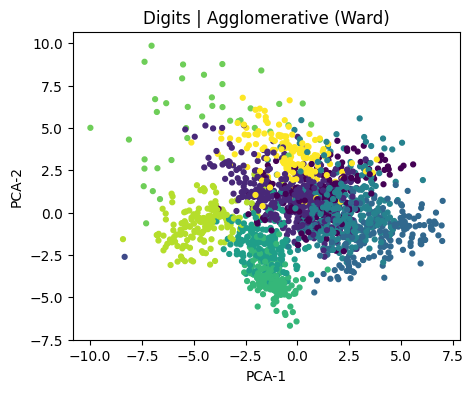

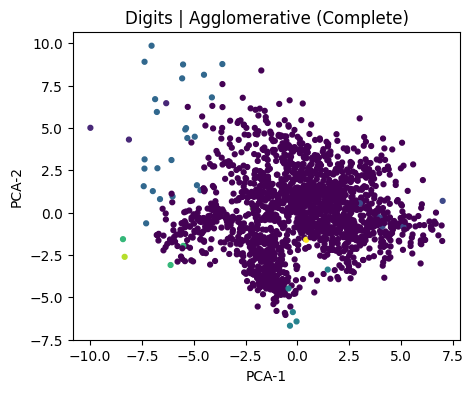

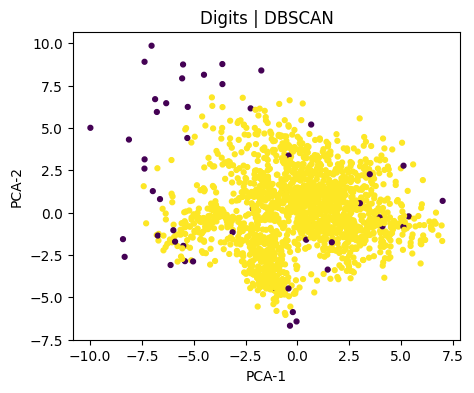

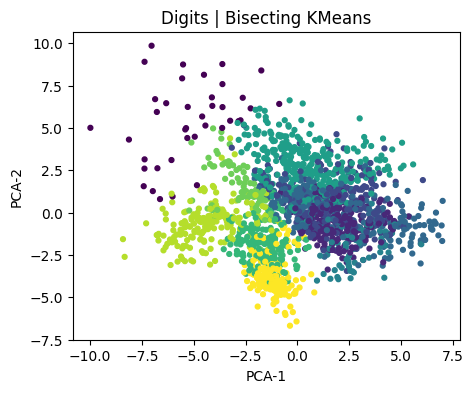

In [ ]:
for key, labels in store_labels.items():
    ds = key.split(" | ")[0]
    X = datasets[ds]["X"]
    plot_clusters(X, labels, title=key)


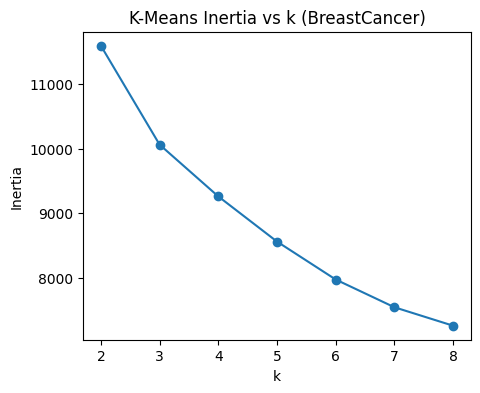

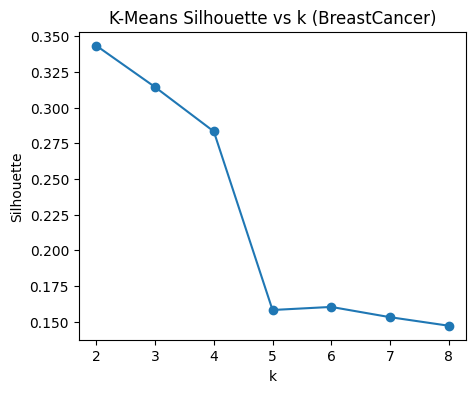

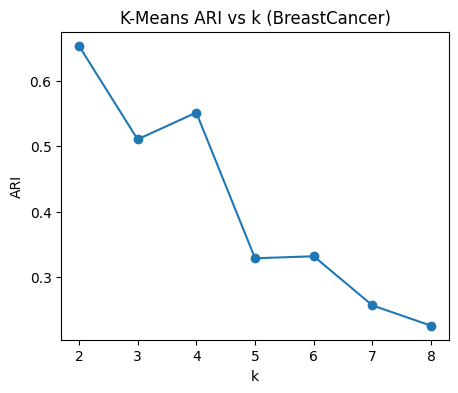

In [ ]:
def kmeans_sweep(X, y, k_min=2, k_max=8):
    ks, inertias, sils, aris = [], [], [], []
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42).fit(X)
        labels = km.labels_
        ks.append(k)
        inertias.append(km.inertia_)
        sils.append(safe_silhouette(X, labels))
        aris.append(adjusted_rand_score(y, labels))
    return np.array(ks), np.array(inertias), np.array(sils), np.array(aris)

# Example sweep on Breast Cancer (challenging structure)
X, y = datasets["BreastCancer"]["X"], datasets["BreastCancer"]["y"]
ks, inertias, sils, aris = kmeans_sweep(X, y)

plt.figure(figsize=(5,4)); plt.plot(ks, inertias, marker="o"); plt.title("K-Means Inertia vs k (BreastCancer)"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.show()
plt.figure(figsize=(5,4)); plt.plot(ks, sils, marker="o"); plt.title("K-Means Silhouette vs k (BreastCancer)"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.show()
plt.figure(figsize=(5,4)); plt.plot(ks, aris, marker="o"); plt.title("K-Means ARI vs k (BreastCancer)"); plt.xlabel("k"); plt.ylabel("ARI"); plt.show()


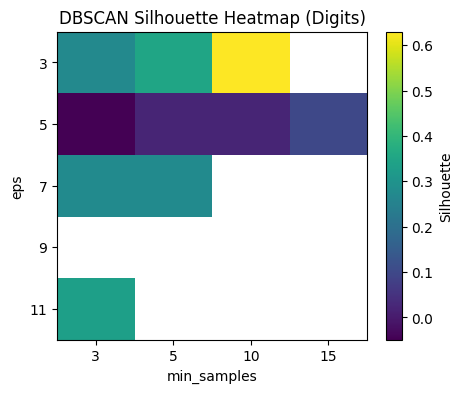

In [ ]:
def dbscan_grid(X, y, eps_list, min_list):
    scores = np.full((len(eps_list), len(min_list)), np.nan)
    for i, eps in enumerate(eps_list):
        for j, m in enumerate(min_list):
            labels = DBSCAN(eps=eps, min_samples=m).fit(X).labels_
            scores[i, j] = safe_silhouette(X, labels)
    return scores

# Example on Digits (hard): try a coarse grid
X, y = datasets["Digits"]["X"], datasets["Digits"]["y"]
eps_list = [3,5,7,9,11]
min_list = [3,5,10,15]
H = dbscan_grid(X, y, eps_list, min_list)

plt.figure(figsize=(5,4))
plt.imshow(H, aspect="auto")
plt.colorbar(label="Silhouette")
plt.xticks(range(len(min_list)), min_list); plt.yticks(range(len(eps_list)), eps_list)
plt.xlabel("min_samples"); plt.ylabel("eps"); plt.title("DBSCAN Silhouette Heatmap (Digits)")
plt.show()


Algorithm Comparisons
Iris: K-Means and Ward Agglomerative worked best. DBSCAN did not do well unless I tuned it.
Wine: K-Means struggled because the shapes were stretched. Agglomerative did a little better. DBSCAN mostly failed.
Breast Cancer: K-Means was not good because the clusters were not round. DBSCAN did the best when tuned.
Digits: This dataset was hard. K-Means++ worked best but still not perfect. DBSCAN mostly failed.
Hyperparameter Sensitivity
For K-Means, inertia went down as k got bigger, but silhouette was best near the real cluster number. For DBSCAN, the results changed a lot with small changes to eps. Too small made too many groups, too big made one big group.

Reflection and Insights
The hardest part was tuning DBSCAN. I had to try different values to make it work.
I learned that scaling is important.  Also learned that no one algorithm works best for every dataset.

Final Takeaways
Scaling features is always needed.
K-Means is fast but not good for odd shapes.
DBSCAN can handle messy data but is hard to tune.